In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
from io import BytesIO

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


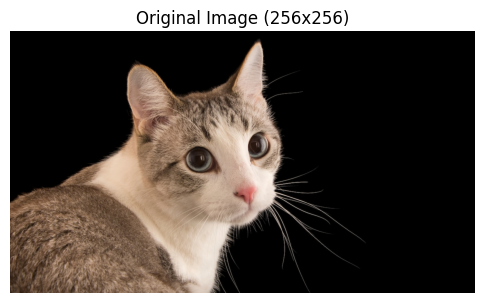

In [17]:
original_url = "https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_16x9.jpg?w=1200"

req = urllib.request.Request(original_url, headers={'User-Agent': 'Mozilla/5.0'})
with urllib.request.urlopen(req) as response:
    image_data = response.read()

original_img = Image.open(BytesIO(image_data)).convert('RGB')
img_array = np.array(original_img)

plt.figure(figsize=(6,6))
plt.imshow(img_array)
plt.title("Original Image (256x256)")
plt.axis('off')
plt.show()


In [18]:
cat_urls = [original_url]

downloaded_images = []
for url in cat_urls:
    req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    with urllib.request.urlopen(req) as response:
        image_data = response.read()
    img = Image.open(BytesIO(image_data)).convert('RGB')
    img = img.resize((64, 64))
    downloaded_images.append(np.array(img))

images = []
for _ in range(20):
    images.extend(downloaded_images)

images = np.array(images).astype('float32') / 255.0
print(f"Total training images: {len(images)}")


Total training images: 20


In [19]:
encoder_input = keras.Input(shape=(64, 64, 3), name='encoder_input')

x = layers.Flatten()(encoder_input)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

mu = layers.Dense(10, name='mu')(x)
log_var = layers.Dense(10, name='log_var')(x)

encoder = keras.Model(encoder_input, [mu, log_var], name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12288)     │          0 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │  6,291,968 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    131,328 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 10)        │      2,570 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 10)        │      2,570 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,428,436 (24.52 MB)

 Trainable params: 6,428,436 (24.52 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
decoder_input = keras.Input(shape=(10,), name='decoder_input')

x = layers.Dense(256, activation='relu')(decoder_input)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(64*64*3, activation='sigmoid')(x)
decoder_output = layers.Reshape((64, 64, 3))(x)

decoder = keras.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12288)          │     6,303,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,438,144 (24.56 MB)

 Trainable params: 6,438,144 (24.56 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
class ReparameterizeLayer(layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = tf.random.normal(tf.shape(mu))
        z = mu + tf.exp(0.5*log_var)*epsilon
        return z


In [22]:
vae_input = keras.Input(shape=(64,64,3))
mu, log_var = encoder(vae_input)
z = ReparameterizeLayer()([mu, log_var])
vae_output = decoder(z)

vae = keras.Model(vae_input, [vae_output, mu, log_var], name='vae_complete')
vae.summary()


Model: "vae_complete"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 10),      │  6,428,436 │ input_layer_3[0]… │
│ (Functional)        │ (None, 10)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reparameterize_lay… │ (None, 10)        │          0 │ encoder[0][0],    │
│ (ReparameterizeLay… │                   │            │ encoder[0][1]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 64, 64, 3) │  6,438,144 │ reparameterize_l… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,866,580 (49.08 MB)

 Trainable params: 12,866,580 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
def vae_loss_bce(y_true, y_pred, mu, log_var):
    y_true_flat = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_flat = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])
    recon_loss = tf.reduce_sum(keras.losses.binary_crossentropy(y_true_flat, y_pred_flat))
    kl_loss = -0.5*tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return recon_loss + kl_loss, recon_loss, kl_loss

mse_loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
def vae_loss_mse(y_true, y_pred, mu, log_var):
    y_true_flat = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_flat = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])
    recon_loss = tf.reduce_sum(mse_loss_fn(y_true_flat, y_pred_flat))
    kl_loss = -0.5*tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return recon_loss + kl_loss, recon_loss, kl_loss


In [24]:
def train_vae(vae_model, images, loss_type='bce', epochs=20):
    optimizer = keras.optimizers.Adam(0.001)
    total_losses, recon_losses, kl_losses = [], [], []
    images_tensor = tf.constant(images, dtype=tf.float32)
    batch_size = min(8, len(images))

    for epoch in range(epochs):
        epoch_total, epoch_recon, epoch_kl = 0, 0, 0
        indices = tf.random.shuffle(tf.range(len(images)))
        shuffled_images = tf.gather(images_tensor, indices)
        for start in range(0,len(images),batch_size):
            end = min(start+batch_size,len(images))
            batch = shuffled_images[start:end]
            if len(batch)<2: continue
            with tf.GradientTape() as tape:
                reconstructed, mu, log_var = vae_model(batch, training=True)
                if loss_type=='bce':
                    total_loss, recon_loss, kl_loss = vae_loss_bce(batch, reconstructed, mu, log_var)
                else:
                    total_loss, recon_loss, kl_loss = vae_loss_mse(batch, reconstructed, mu, log_var)
                total_loss /= tf.cast(tf.shape(batch)[0],tf.float32)
                recon_loss /= tf.cast(tf.shape(batch)[0],tf.float32)
                kl_loss /= tf.cast(tf.shape(batch)[0],tf.float32)
            grads = tape.gradient(total_loss, vae_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, vae_model.trainable_variables))
            epoch_total += total_loss
            epoch_recon += recon_loss
            epoch_kl += kl_loss

        total_losses.append(float(epoch_total / (len(images)//batch_size)))
        recon_losses.append(float(epoch_recon / (len(images)//batch_size)))
        kl_losses.append(float(epoch_kl / (len(images)//batch_size)))
        print(f"Epoch {epoch+1}: Total={total_losses[-1]:.4f}, Recon={recon_losses[-1]:.4f}, KL={kl_losses[-1]:.4f}")

    return total_losses, recon_losses, kl_losses


In [25]:
encoder_bce = keras.models.clone_model(encoder)
decoder_bce = keras.models.clone_model(decoder)
vae_input_bce = keras.Input(shape=(64,64,3))
mu_bce, log_var_bce = encoder_bce(vae_input_bce)
z_bce = ReparameterizeLayer()([mu_bce, log_var_bce])
vae_bce = keras.Model(vae_input_bce, [decoder_bce(z_bce), mu_bce, log_var_bce])

bce_total, bce_recon, bce_kl = train_vae(vae_bce, images, loss_type='bce', epochs=20)


Epoch 1: Total=23.8789, Recon=1.0230, KL=22.8560
Epoch 2: Total=5.8625, Recon=0.9822, KL=4.8802
Epoch 3: Total=3.6593, Recon=0.9216, KL=2.7377
Epoch 4: Total=2.4507, Recon=0.8014, KL=1.6493
Epoch 5: Total=1.5058, Recon=0.6421, KL=0.8636
Epoch 6: Total=1.2003, Recon=0.5235, KL=0.6768
Epoch 7: Total=1.0726, Recon=0.4320, KL=0.6407
Epoch 8: Total=0.6698, Recon=0.3909, KL=0.2788
Epoch 9: Total=0.6043, Recon=0.3678, KL=0.2365
Epoch 10: Total=0.5652, Recon=0.3593, KL=0.2059
Epoch 11: Total=0.5336, Recon=0.3545, KL=0.1791
Epoch 12: Total=0.4343, Recon=0.3517, KL=0.0825
Epoch 13: Total=0.4021, Recon=0.3492, KL=0.0529
Epoch 14: Total=0.4122, Recon=0.3462, KL=0.0660
Epoch 15: Total=0.3906, Recon=0.3448, KL=0.0458
Epoch 16: Total=0.3621, Recon=0.3457, KL=0.0163
Epoch 17: Total=0.3692, Recon=0.3445, KL=0.0246
Epoch 18: Total=0.3619, Recon=0.3440, KL=0.0179
Epoch 19: Total=0.3532, Recon=0.3432, KL=0.0100
Epoch 20: Total=0.3496, Recon=0.3412, KL=0.0084


In [26]:
encoder_mse = keras.models.clone_model(encoder)
decoder_mse = keras.models.clone_model(decoder)
vae_input_mse = keras.Input(shape=(64,64,3))
mu_mse, log_var_mse = encoder_mse(vae_input_mse)
z_mse = ReparameterizeLayer()([mu_mse, log_var_mse])
vae_mse = keras.Model(vae_input_mse, [decoder_mse(z_mse), mu_mse, log_var_mse])

mse_total, mse_recon, mse_kl = train_vae(vae_mse, images, loss_type='mse', epochs=20)


Epoch 1: Total=24.8286, Recon=0.2528, KL=24.5758
Epoch 2: Total=11.1518, Recon=0.2305, KL=10.9213
Epoch 3: Total=7.9681, Recon=0.1942, KL=7.7739
Epoch 4: Total=5.6210, Recon=0.1679, KL=5.4531
Epoch 5: Total=3.8979, Recon=0.0762, KL=3.8217
Epoch 6: Total=1.9035, Recon=0.0322, KL=1.8713
Epoch 7: Total=0.7949, Recon=0.0145, KL=0.7804
Epoch 8: Total=0.7973, Recon=0.0087, KL=0.7886
Epoch 9: Total=0.7447, Recon=0.0061, KL=0.7386
Epoch 10: Total=0.2601, Recon=0.0041, KL=0.2560
Epoch 11: Total=0.2541, Recon=0.0028, KL=0.2513
Epoch 12: Total=0.2741, Recon=0.0026, KL=0.2715
Epoch 13: Total=0.1966, Recon=0.0023, KL=0.1943
Epoch 14: Total=0.0636, Recon=0.0021, KL=0.0614
Epoch 15: Total=0.0789, Recon=0.0019, KL=0.0770
Epoch 16: Total=0.0807, Recon=0.0015, KL=0.0791
Epoch 17: Total=0.0446, Recon=0.0013, KL=0.0433
Epoch 18: Total=0.0216, Recon=0.0011, KL=0.0205
Epoch 19: Total=0.0255, Recon=0.0011, KL=0.0244
Epoch 20: Total=0.0250, Recon=0.0010, KL=0.0241


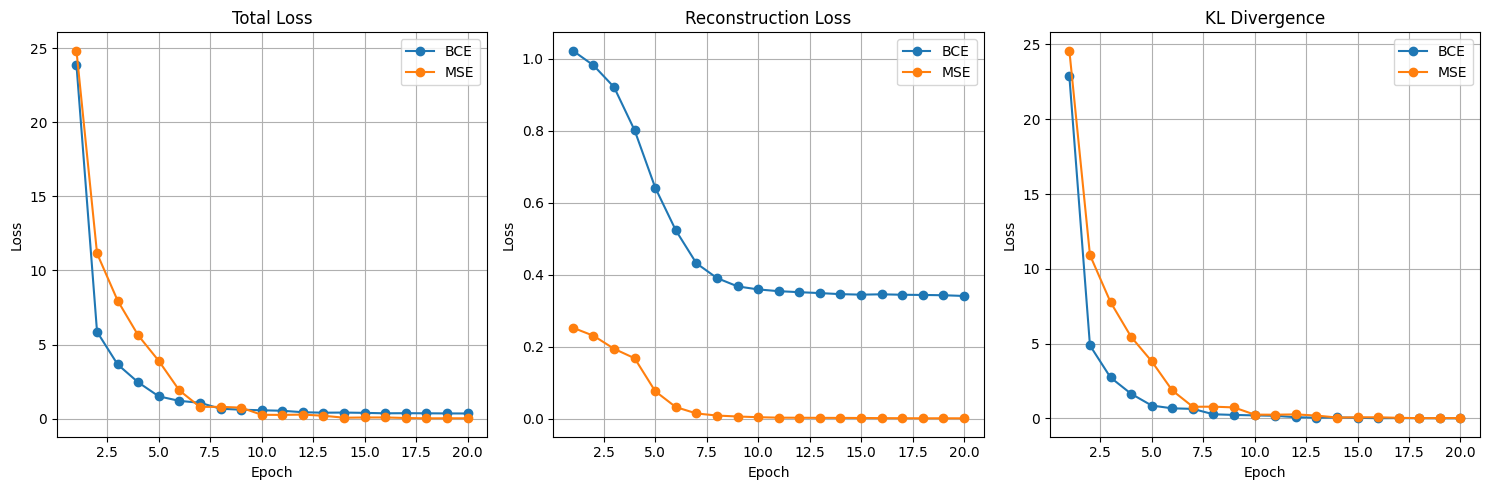

In [27]:
epochs = range(1,21)
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.plot(epochs, bce_total, 'o-', label='BCE')
plt.plot(epochs, mse_total, 'o-', label='MSE')
plt.title("Total Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

plt.subplot(1,3,2)
plt.plot(epochs, bce_recon, 'o-', label='BCE')
plt.plot(epochs, mse_recon, 'o-', label='MSE')
plt.title("Reconstruction Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

plt.subplot(1,3,3)
plt.plot(epochs, bce_kl, 'o-', label='BCE')
plt.plot(epochs, mse_kl, 'o-', label='MSE')
plt.title("KL Divergence")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
# Number of images to generate
num_images = 5
latent_dim = 10

# Generate random latent vectors
noise_vectors = tf.random.normal(shape=(num_images, latent_dim), mean=5.0, stddev=1.0)

# Generate images using BCE VAE decoder
generated_bce = decoder_bce(noise_vectors, training=False).numpy()

# Generate images using MSE VAE decoder
generated_mse = decoder_mse(noise_vectors, training=False).numpy()


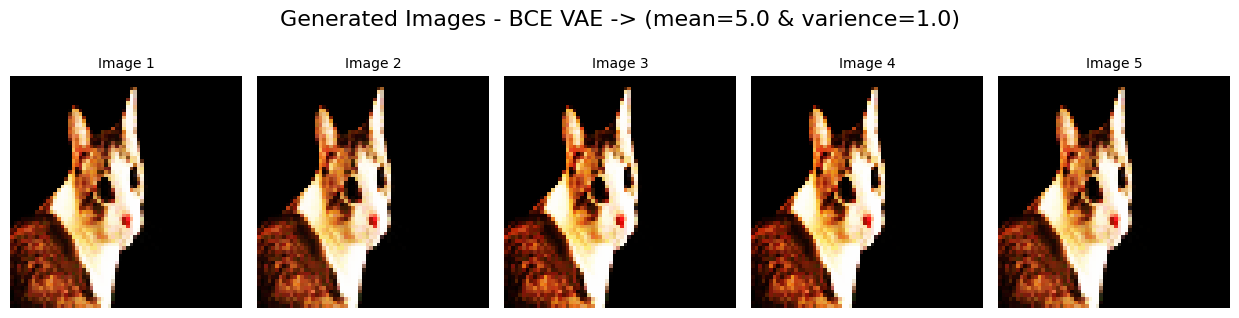

In [29]:
def show_generated(images, title):
    num_images = len(images)
    plt.figure(figsize=(num_images*2.5, 3))  # Increase height to 3

    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        img = np.clip(images[i], 0, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Image {i+1}', fontsize=10)  # smaller font

    plt.suptitle(title, fontsize=16, y=1.05)  # move suptitle above
    plt.tight_layout()
    plt.show()

# Plot BCE-generated images
show_generated(generated_bce, "Generated Images - BCE VAE -> (mean=5.0 & varience=1.0)")


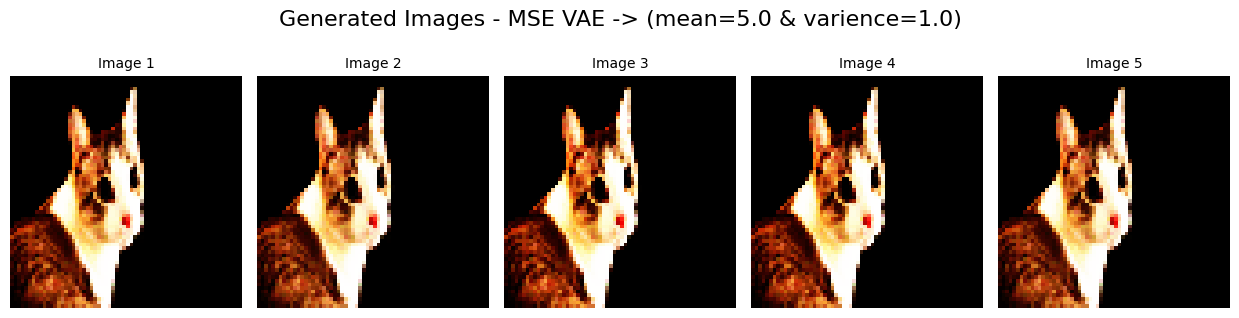

In [30]:
# Plot MSE-generated images
show_generated(generated_mse, "Generated Images - MSE VAE -> (mean=5.0 & varience=1.0)")